#Assignment 3:
    test if the distribution of ages can be modelled by a Gaussian
    
    1) all riders
    
    2) summer riders vs winder riders
    
    use 2 tests, you can use KS, AD, or get creative. use KL or chi2 like you did in Assignment2 or perhaps new ones!
    
    CHALLANGE! look for a better distribution to fit the data! see notes on how to input a number of different 
    distributions into the test, not just 'norm' and the few others available by keyword

my usual imports and setups

In [1]:
import pylab as pl
import pandas as pd
import numpy as np
import zipfile as zf
%pylab inline

import os
'''
#this makes my plots pretty! but it is totally not mandatory to do it
import json
s = json.load( open(os.getenv ('PUI2015')+"/fbb_matplotlibrc.json") )
pl.rcParams.update(s)
'''
#i know i will use scipy for the tests
import scipy.stats

Populating the interactive namespace from numpy and matplotlib


Load one year's worth of data. We load every nth line (set below). I don't suspect any periodicity in the data, especially on the timescale between entries in the data, so choosing every nth is convenient and keeps the scale of the data in the files (instead of choosing a set number from every data set).


In [5]:
cbcols = ['birth year', 'gender', 'usertype', 'starttime']
df=pd.DataFrame()
#every_nth = 100   #debug line
every_nth = 10

for directory, subdirectories, files in os.walk(os.getenv ('PUI2015')+'/citibikes/data'):
    for f in files:
        print f   #debug line
        mypath=os.path.join(directory, f)
        with zf.ZipFile(mypath, 'r') as z:    
            frame=pd.read_csv(z.open(z.namelist()[0]), usecols = cbcols, iterator=True, chunksize=10000)
        for chunk in frame:
            reduced=chunk[::every_nth]
            df=pd.concat([df, reduced], ignore_index=True)

201507-citibike-tripdata.zip
201502-citibike-tripdata.zip
201503-citibike-tripdata.zip
201411-citibike-tripdata.zip
201410-citibike-tripdata.zip
201501-citibike-tripdata.zip
201509-citibike-tripdata.zip
201506-citibike-tripdata.zip
201505-citibike-tripdata.zip
201508-citibike-tripdata.zip
201412-citibike-tripdata.zip
201504-citibike-tripdata.zip


In [6]:
len(df)

86918

Seasons of 2014/5:
* WINTER SOLSTICE 	December 21
* SPRING EQUINOX 	March 20
* SUMMER SOLSTICE 	June 21
* FALL EQUINOX 	September 23

Add columns for date and age:

In [7]:
#this is gonna take FOREVER if every_nth is small
df['date'] = pd.to_datetime(df['starttime'])

In [13]:
df['age'] = df.date.dt.year-df['birth year']

Calculate seasons and add as a column in the dataframe.

In [29]:
def season(d):
    dwinter = pd.Timestamp('2014-12-21')
    dspring = pd.Timestamp('2015-03-20')
    dsummer = pd.Timestamp('2015-06-21')
    dautumn = pd.Timestamp('2015-09-23')
    
    if (d < dspring) & (d >= dwinter):
        return 'winter'
    elif (d < dsummer) & (d >= dspring):
        return 'spring'
    elif (d < dautumn) & (d >= dsummer):
        return 'summer'
    else:
        return 'autumn'

In [30]:
df['season'] = map(season,df.date)

Create a view (I think, not a copy) with only Subscriber data


In [36]:
df1=df[df['usertype']=='Subscriber']

Divide into 10 year age bins

,autumn,spring,summer,winter
age,,,,
"(10, 20]",329,211,350,93
"(20, 30]",5632,5511,8561,1925
"(30, 40]",5767,6518,9539,2280
"(40, 50]",3873,4387,5788,1755
"(50, 60]",2359,2821,3660,1146
"(60, 70]",612,816,1083,344
"(70, 80]",70,92,116,48
"(80, 90]",0,2,2,2


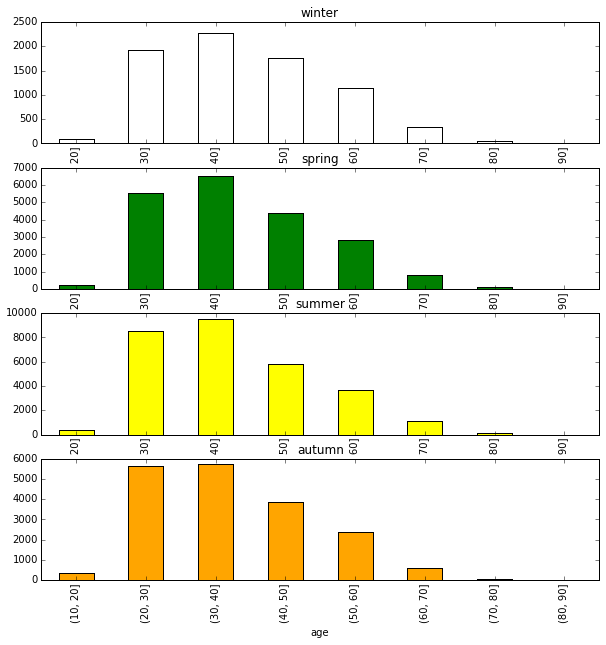

In [166]:
bins = np.arange(10, 99, 10)
age_dist={}

seasons = ['winter', 'spring', 'summer', 'autumn']
colors = ['white', 'green', 'yellow', 'orange']
fig, ax = pl.subplots(nrows=4, ncols=1)

for i, season in enumerate(seasons):
    df1[df1['season']==season].age.groupby(pd.cut(df1[df1['season']==season].age, bins)).size()\
        .plot(kind='bar', title=season, color=colors[i], ax = ax[i])
    age_dist[season] = df1[df1['season']==season].age.groupby(pd.cut(df1[df1['season']==season].age, bins)).size()

age_df = pd.DataFrame(age_dist)
age_df.fillna(0, inplace=True)
age_df

The distributions look similar, and summer has much larger counts than winter (which we would expect).

## lets run the scipy KS test

In [150]:
ks={}

dists = {'norm': {}, 
         'cauchy': {}, 
         'poisson': {'args': (35,)}, 
         'gamma': {'args': (35,)}, 
         'binom': {'args': (10,0.2)},
         'lognorm': {'args': (35,)}}

for season in seasons:
    ks[season] = {}
    for dist, params in dists.iteritems():
        ks[season][dist]=scipy.stats.kstest(age_df[season], dist, **params)
        print "%s, %s fit"%(season, dist), 'KS: %.3f p-val: %.5f'%(ks[season][dist])

winter, lognorm fit KS: 0.508 p-val:0.01950
winter, cauchy fit KS: 0.868 p-val:0.00000
winter, norm fit KS: 0.977 p-val:0.00000
winter, poisson fit KS: 0.860 p-val:0.00000
winter, binom fit KS: 0.875 p-val:0.00000
winter, gamma fit KS: 0.854 p-val:0.00000
spring, lognorm fit KS: 0.508 p-val:0.01950
spring, cauchy fit KS: 0.872 p-val:0.00000
spring, norm fit KS: 0.977 p-val:0.00000
spring, poisson fit KS: 0.875 p-val:0.00000
spring, binom fit KS: 0.875 p-val:0.00000
spring, gamma fit KS: 0.875 p-val:0.00000
summer, lognorm fit KS: 0.508 p-val:0.01950
summer, cauchy fit KS: 0.872 p-val:0.00000
summer, norm fit KS: 0.977 p-val:0.00000
summer, poisson fit KS: 0.875 p-val:0.00000
summer, binom fit KS: 0.875 p-val:0.00000
summer, gamma fit KS: 0.875 p-val:0.00000
autumn, lognorm fit KS: 0.423 p-val:0.08155
autumn, cauchy fit KS: 0.870 p-val:0.00000
autumn, norm fit KS: 0.875 p-val:0.00000
autumn, poisson fit KS: 0.875 p-val:0.00000
autumn, binom fit KS: 0.875 p-val:0.00000
autumn, gamma fit 

The KS test rejects the null hypothesis in every case, $\alpha = 0.05$. The lognormal has non-zero p-values, and the lognormal distribution looks closest to the histograms.

## Anderson test

In [149]:
ad={}
dists_and = ['norm', 'expon', 'gumbel', 'logistic']
def rejectanderson(ad, crit):
    if ad>crit:
        return 'null REJECTED (to 5% confidence)'
    else:
        return 'null NOT rejected (to 5% confidence)'
for season in seasons:
    ad[season] = {}
    for dist in dists_and:
        ad[season][dist]=scipy.stats.anderson(age_df[season], dist=dist) #, **params)
        print "%s, %s fit"%(season, dist), \
              ', AD: %.3f'%(ad[season][dist][0]), \
              ', crit. val.: %.3f'%(ad[season][dist][1][2]), \
              '%s'%(rejectanderson(ad[season][dist][0], ad[season][dist][1][2]))

winter, norm fit , AD: 0.515 , crit. val.: 0.709 null NOT rejected (to 5% confidence)
winter, expon fit , AD: 1.367 , crit. val.: 1.247 null REJECTED (to 5% confidence)
winter, gumbel fit , AD: 0.549 , crit. val.: 0.707 null NOT rejected (to 5% confidence)
winter, logistic fit , AD: 0.548 , crit. val.: 0.640 null NOT rejected (to 5% confidence)
spring, norm fit , AD: 0.485 , crit. val.: 0.709 null NOT rejected (to 5% confidence)
spring, expon fit , AD: 1.643 , crit. val.: 1.247 null REJECTED (to 5% confidence)
spring, gumbel fit , AD: 0.528 , crit. val.: 0.707 null NOT rejected (to 5% confidence)
spring, logistic fit , AD: 0.515 , crit. val.: 0.640 null NOT rejected (to 5% confidence)
summer, norm fit , AD: 0.507 , crit. val.: 0.709 null NOT rejected (to 5% confidence)
summer, expon fit , AD: 1.651 , crit. val.: 1.247 null REJECTED (to 5% confidence)
summer, gumbel fit , AD: 0.588 , crit. val.: 0.707 null NOT rejected (to 5% confidence)
summer, logistic fit , AD: 0.527 , crit. val.: 0.

The Anderson test is only slightly less conservative. It rejects the null hypothesis that the data come from the exponential distribution for all seasons, but does not reject for all other distributions.